## Bayesian parameter estimation using Importance Sampling

In this notebook we illustrate another way to sample from a posterior pdf, that is, using importance sampling. One samples from a proposal distribution, then the samples are weighted to account for the discrepancy between the proposal pdf and the target posterior pdf. The BayesParameterEstimation class using IS returns samples from the proposal and weigths for each sample. If one requires a set of un-weighted samples, one can use the resample function from UQpy.Utilities. This notebook also illustrates the use of simple diagnostics for IS.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from UQpy.Utilities import IS_diagnostics, resample

In [4]:
def pdf_from_kde(domain, samples1d):
    bandwidth = 1.06 * np.std(samples1d) * samples1d.size ** (-1/5)
    kde = KernelDensity(bandwidth=bandwidth).fit(samples1d.reshape((-1,1)))
    log_dens = kde.score_samples(domain)
    return np.exp(log_dens)

## Probability model

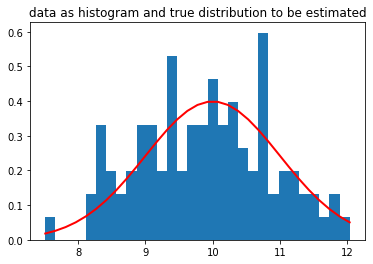

In [29]:
# Generate data from a probability model, here a Gaussian pdf, then learn its parameters, 
# mean and covariance, from this data

np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 100).reshape((-1, 1))
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In [30]:
# create an instance of class Model
prior = Distribution(['uniform','lognormal'], params=[[0, 15], [1, 0, 1]])
inference_model = InferenceModel(distribution_object=Distribution('normal'), nparams=2, prior=prior)

In [33]:
# Learn the unknown parameters using IS
bayes_estimator = BayesParameterEstimation(inference_model=inference_model, data=data, sampling_method='IS', 
                                           nsamples=50000)

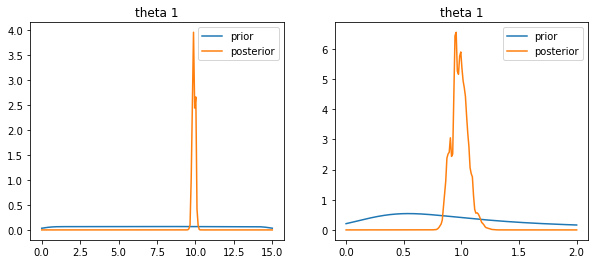

In [34]:
s_prior = bayes_estimator.sampler.samples
s_posterior = bayes_estimator.sampler.resample()

# print results
fig, ax = plt.subplots(1, 2, figsize=(10,4))

domain = np.linspace(0, 15, 200)[:, np.newaxis]
pdf_ = pdf_from_kde(domain, s_prior[:, 0])
ax[0].plot(domain, pdf_, label='prior')
pdf_ = pdf_from_kde(domain, s_posterior[:, 0])
ax[0].plot(domain, pdf_, label='posterior')
ax[0].legend()
ax[0].set_title('theta 1')

domain = np.linspace(0, 2, 200)[:, np.newaxis]
pdf_ = pdf_from_kde(domain, s_prior[:, 1])
ax[1].plot(domain, pdf_, label='prior')
pdf_ = pdf_from_kde(domain, s_posterior[:, 1])
ax[1].plot(domain, pdf_, label='posterior')
ax[1].legend()
ax[1].set_title('theta 1')

plt.show()

## Regression model - $y=X \theta + \epsilon$

In [18]:
# Generate data from a quadratic equation, add some noise to it
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
h = RunModel(model_script='pfn_models.py', model_object_name = 'model_quadratic', var_names = ['theta_1', 'theta_2'])
h.run(samples=param_true)
data = h.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[  0.88800362   2.17416975  -1.55535249   0.35123257   1.37954543
   2.72211779   5.13416297   5.88735699   7.73984446   8.71722428
  11.05301239  12.37775971  15.24325403  16.62065985  18.90818322
  19.95528833  25.22278343  26.4988657   30.10858361  32.89652762
  37.20077449  41.14792138  44.70248145  48.31034355  51.86106219
  55.50304223  61.84061943  67.25475139  70.6205419   74.85624822
  79.77880021  87.48111313  91.36905585  97.03052221 103.48704527
 109.48342824 114.6432905  122.01380986 129.54650306 135.38479766
 139.85005424 149.10491907 156.23818156 162.8857967  170.79851272
 178.79167937 185.3400844  193.50986315 201.73782083 211.43844722]


In [19]:
inference_model = InferenceModel(nparams=2, run_model_object=h, error_covariance=error_covariance)

In [20]:
bayes_estimator = BayesParameterEstimation(data=data, inference_model=inference_model, sampling_method='IS', 
                                           nsamples=200000,
                                           proposal=Distribution(['normal','normal'], params=[[0, 2], [0, 2]]))

1.0000000000000004


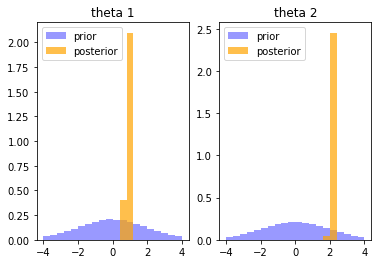

In [21]:
s = bayes_estimator.samples
w = bayes_estimator.weights
print(sum(w))

# print results
fig, ax = plt.subplots(1,2)
for i in range(2):
    ax[i].hist(x=s[:,i], weights=None, density=True, range=(-4, 4), bins = 20, color='blue', alpha=0.4, label='prior')
    ax[i].hist(x=s[:,i], weights=w, density=True, range=(-4, 4), bins = 20, color='orange', alpha=0.7, label='posterior')
    ax[i].legend()
    ax[i].set_title('theta {}'.format(i+1))

plt.show()

Diagnostics for Importance Sampling 

Effective sample size is ne=13.643784651004841, out of a total number of samples=200000 

max_weight = 0.13226302676074997, min_weight = 0.0 



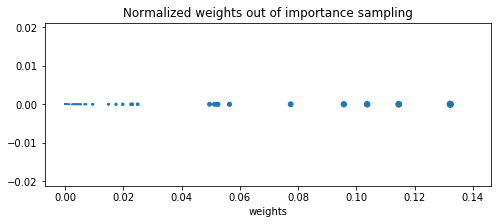

In [23]:
IS_diagnostics(sampling_outputs = bayes_estimator.sampler, graphics=True)

In this example, the effective sample size is about 20 samples, out of a total of 20000 samples that were generated and evaluated. A pdf approximation based on 20 samples only is likely to be very poor.